In [12]:
# imports
import numpy as np
from typing import Tuple, Dict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [13]:
# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """

    def __init__(self, K: int=3, n_init: int=20, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance

        Inputs:
            K            -> integer number of clusters to assign
            n_init       -> integer number of times the algorithm will be applied when training
            max_iters    -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.K          = K
        self.n_init     = n_init
        self.centroids  = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters  = max_iters

    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters

    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
            list of numpy arrays of centroid for cluster, each array with shape:
            [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X : np.array, cluster_assignment : np.array,
                       centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:],
                                         X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)

    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
            numpy array of centroids with shape: [K, number_features]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS

        Inputs:
            X -> numpy array of input features of assumed  shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf

        # loop over all iterations requested
        for _ in range(self.n_init):

            # initialise centroids
            centroids     = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration     = 0
            while (not np.array_equal(centroid_diff,np.zeros(self.K))) and iteration < self.max_iters:
                # assign samples to clusters
                cluster_assignment = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, cluster_assignment)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration    += 1
                old_centroids = np.copy(centroids)

            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids  = centroids

    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids

        Input:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)

    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)

        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)

    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)

        Output:
            numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids

    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K,
                'n_init':self.n_init,
                'max_iters':self.max_iters}

In [14]:
data = pd.read_excel("AirQualityUCI.xlsx")
df = pd.DataFrame(data)

In [15]:
# statistics of the data
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [16]:
df['NMHC(GT)'].value_counts()

-200    8443
 66       14
 40        9
 29        9
 88        8
        ... 
 422       1
 424       1
 339       1
 445       1
 307       1
Name: NMHC(GT), Length: 430, dtype: int64

In [17]:
df.replace(to_replace= -200, value= np.NaN, inplace= True)
df = df.dropna()

In [18]:
# df = df.drop(columns=['Date', 'Time'], axis= 1)
used_df = df[['NMHC(GT)', 'RH']]
used_df = used_df.to_numpy()
used_df

array([[150.        ,  48.87500095],
       [112.        ,  47.69999981],
       [ 88.        ,  53.97500038],
       ...,
       [212.        ,  66.10000038],
       [275.        ,  66.875     ],
       [275.        ,  66.75000191]])

In [19]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(used_df)

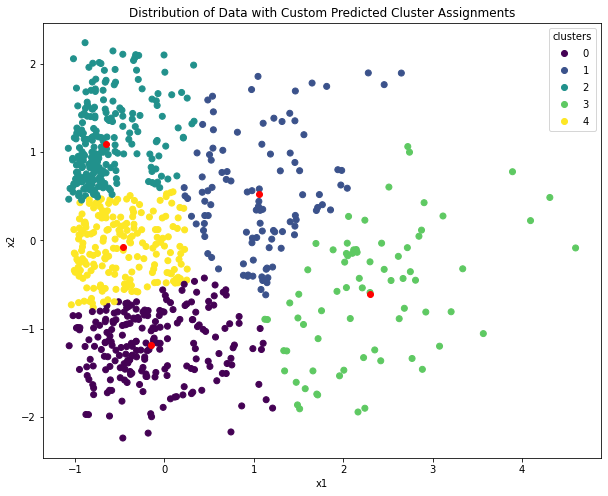

In [20]:
# Buat model KMeans
clt = KMeans(K= 5,max_iters=300)

# Cocokkan model dengan data
clt.fit(data_scaled)

# Cluster centers
centers = clt.return_centroids()
y = (data_scaled[:,1] + data_scaled[:,0])/2
y = y.astype(int)

# Dapatkan prediksi
y_pred = clt.predict(data_scaled)

# add -2 to change the value from 0,1,2,3,4 to -2,-1,0,1,2
y_pred = y_pred.astype(int)

# Dapatkan prediksi sentroid
centers_pred = clt.return_centroids()

# Visualisasikan prediksi
fig, ax    = plt.subplots(figsize=(10,8))
sc         = ax.scatter(data_scaled[:,0],data_scaled[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Custom Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

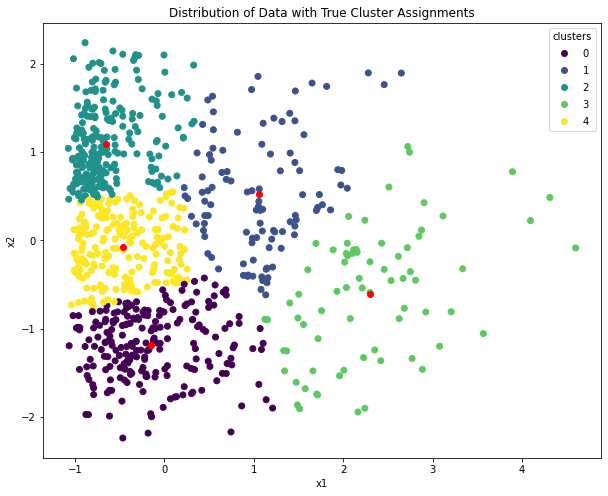

In [21]:
# visualise data
fig, ax    = plt.subplots(figsize=(10,8))
sc         = ax.scatter(data_scaled[:,0],data_scaled[:,1],c=y_pred)
sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [22]:
# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[2,1,0,3,4]])}')

# Kalibrasikan pelabelan (if needed)
# idx_0         = y_pred == 0
# idx_1         = y_pred == 1
# idx_2         = y_pred == 2
# idx_3         = y_pred == 3
# idx_4         = y_pred == 4
# y_pred[idx_0] = 2
# y_pred[idx_1] = 1
# y_pred[idx_2] = 0
# y_pred[idx_3] = 3
# y_pred[idx_4] = 4

acc = accuracy_score(y.round(), y_pred)
pre = precision_score(y.round(), y_pred, average='weighted') 
rec = recall_score(y.round(), y_pred, average='weighted')
f1 = f1_score(y.round(), y_pred, average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 0.5558724383371426
Accuracy score: 0.2648
Precision score: 0.7927
Recall score: 0.2648
F1 score: 0.3783


C:\Users\M-SI\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\M-SI\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
